# UE Computer Vision | Project : Visual tracking of video objects
# Results scoring

In [14]:
import numpy as np
import glob
from tqdm import tqdm
from skimage import io, img_as_ubyte
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import matplotlib
from skimage.measure import regionprops

In [2]:
#Params
sequence_name = "bear"
methods_raw = ["HS", "LK", "Fa", "raft"]
methods_tested = []
for method in methods_raw:
    methods_tested.append("direct-"+method)
    methods_tested.append("direct-"+method+"-post")
    methods_tested.append("seq-"+method)
    methods_tested.append("seq-"+method+"-post")
#methods_tested = ["seq-LK-old", "seq-LK"]
save_gifs = False
save_metrics = False

In [3]:
#get number frames
files = glob.glob("data/sequences-train/"+sequence_name+"-*.png")
im_begin = 1
im_end = len(files)

Let us visualize some images with associated groundtruth masks.

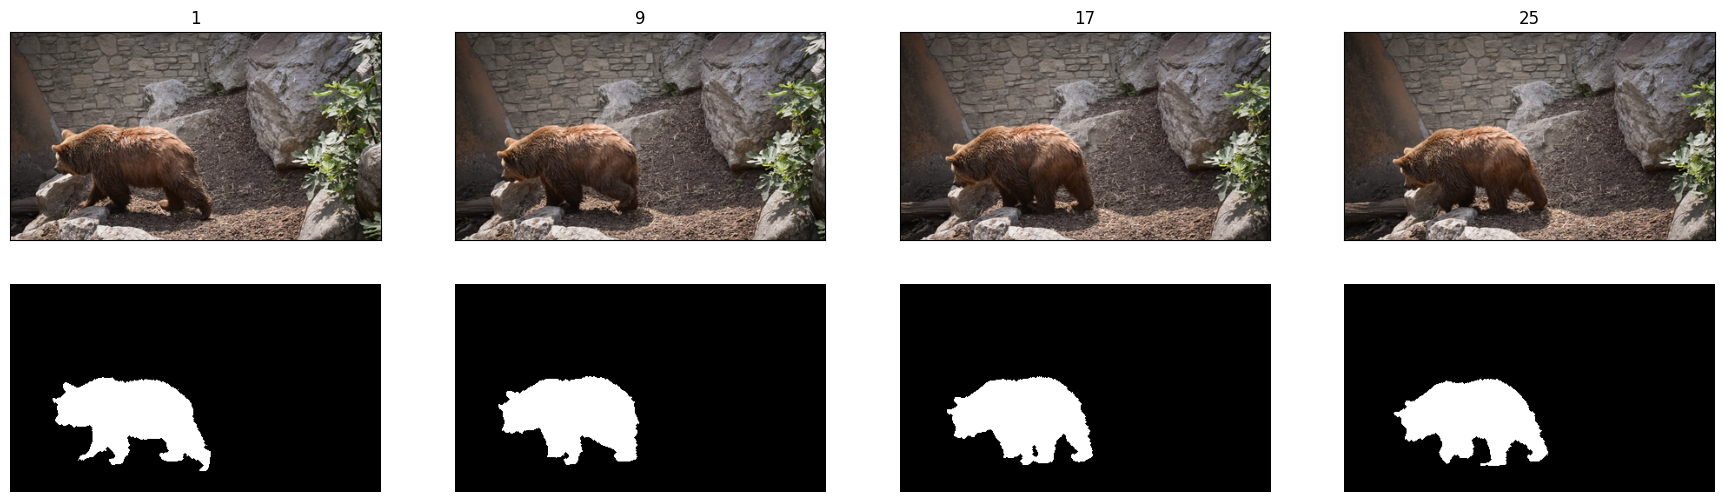

In [4]:
plt.figure(figsize=(22, 6))
for idx, im in enumerate([i for i in range(1, im_end, int(im_end/3.))]):
    img_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im))
    mask_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im))
    plt.subplot(2,4,idx+1), plt.title('%i' %(im)), plt.imshow(img_current), plt.xticks([]), plt.yticks([])
    plt.subplot(2,4,idx+5), plt.imshow(mask_current,cmap='gray'), plt.xticks([]), plt.yticks([])
    plt.axis('off')
plt.show()

## Assessment

The `dice_assessment()`, `db_eval_boundary()` and `centroid_assessment()` functions provided below will allow you to evaluate the implemented method. These functions take as inputs both groundtruth and estimated masks of the foreground object. 

`dice_assessment()` evaluates the overlap between the two masks while `db_eval_boundary()` quantifies the quality of the estimated contours. Each function returns a score between 0% (poor quality) and 100% (perfect quality).

`centroid_assessment()` comptes the *Euclidean* distance between groundtruth and estimated centroids.

In [5]:
def dice_assessment(groundtruth, estimated, label=255):
    A = groundtruth == label
    B = estimated == label              
    TP = len(np.nonzero(A*B)[0])
    FN = len(np.nonzero(A*(~B))[0])
    FP = len(np.nonzero((~A)*B)[0])
    DICE = 0
    if (FP+2*TP+FN) != 0: 
        DICE = float(2)*TP/(FP+2*TP+FN)
    return DICE*100

In [6]:
def db_eval_boundary(foreground_mask,gt_mask,bound_th=0.008):
    """
    Compute mean,recall and decay from per-frame evaluation.
    Calculates precision/recall for boundaries between foreground_mask and
    gt_mask using morphological operators to speed it up.

    Arguments:
        foreground_mask (ndarray): binary segmentation image.
        gt_mask         (ndarray): binary annotated image.

    Returns:
        F (float): boundaries F-measure
    """
    assert np.atleast_3d(foreground_mask).shape[2] == 1

    bound_pix = bound_th if bound_th >= 1 else \
            np.ceil(bound_th*np.linalg.norm(foreground_mask.shape))

    # Get the pixel boundaries of both masks
    fg_boundary = seg2bmap(foreground_mask);
    gt_boundary = seg2bmap(gt_mask);

    from skimage.morphology import binary_dilation,disk

    fg_dil = binary_dilation(fg_boundary,disk(bound_pix))
    gt_dil = binary_dilation(gt_boundary,disk(bound_pix))

    # Get the intersection
    gt_match = gt_boundary * fg_dil
    fg_match = fg_boundary * gt_dil

    # Area of the intersection
    n_fg     = np.sum(fg_boundary)
    n_gt     = np.sum(gt_boundary)

    #% Compute precision and recall
    if n_fg == 0 and  n_gt > 0:
        precision = 1
        recall = 0
    elif n_fg > 0 and n_gt == 0:
        precision = 0
        recall = 1
    elif n_fg == 0  and n_gt == 0:
        precision = 1
        recall = 1
    else:
        precision = np.sum(fg_match)/float(n_fg)
        recall    = np.sum(gt_match)/float(n_gt)

    # Compute F measure
    if precision + recall == 0:
        F = 0
    else:
        F = 2*precision*recall/(precision+recall);

    return F*100.

def seg2bmap(seg,width=None,height=None):
    """
    From a segmentation, compute a binary boundary map with 1 pixel wide
    boundaries.  The boundary pixels are offset by 1/2 pixel towards the
    origin from the actual segment boundary.

    Arguments:
        seg     : Segments labeled from 1..k.
        width   : Width of desired bmap  <= seg.shape[1]
        height  : Height of desired bmap <= seg.shape[0]

    Returns:
        bmap (ndarray):	Binary boundary map.
    """

    seg = seg.astype(bool)
    seg[seg>0] = 1

    assert np.atleast_3d(seg).shape[2] == 1

    width  = seg.shape[1] if width  is None else width
    height = seg.shape[0] if height is None else height

    h,w = seg.shape[:2]

    ar1 = float(width) / float(height)
    ar2 = float(w) / float(h)

    assert not (width>w | height>h | abs(ar1-ar2)>0.01),\
        'Can''t convert %dx%d seg to %dx%d bmap.'%(w,h,width,height)

    e  = np.zeros_like(seg)
    s  = np.zeros_like(seg)
    se = np.zeros_like(seg)

    e[:,:-1]    = seg[:,1:]
    s[:-1,:]    = seg[1:,:]
    se[:-1,:-1] = seg[1:,1:]

    b        = seg^e | seg^s | seg^se
    b[-1,:]  = seg[-1,:]^e[-1,:]
    b[:,-1]  = seg[:,-1]^s[:,-1]
    b[-1,-1] = 0

    if w == width and h == height:
        bmap = b
    else:
        bmap = np.zeros((height,width))
        for x in range(w):
            for y in range(h):
                if b[y,x]:
                    j = 1+np.floor((y-1)+height / h)
                    i = 1+np.floor((x-1)+width  / h)
                    bmap[j,i] = 1;

    return bmap

In [7]:
def centroid_assessment(groundtruth,estimated):
    a = regionprops(groundtruth)
    b = regionprops(estimated)
    return np.linalg.norm(np.array(a[0].centroid)-np.array(b[0].centroid))

In [8]:
img_begin = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im_begin))
mask_begin = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im_begin))

results = {}
for method in methods_tested:
    dices, fmeasures, centroid_dist, visu = [], [], [], []
    print("Computing scores for", method)
    for im in tqdm(range(im_begin+1,im_end+1)):
        img_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.bmp'%(3,im))
        mask_current = io.imread("data/sequences-train/"+sequence_name+'-%0*d.png'%(3,im))

        mask_computed = io.imread("data/mask-outputs/"+method+"_"+sequence_name+'/%0*d.png'%(3,im))
        visu.append(mark_boundaries(mark_boundaries(img_current, mask_current, color=(0,1,0)), mask_computed, color=(1,0,0)))
        dices.append(dice_assessment(mask_current, mask_computed))
        fmeasures.append(db_eval_boundary(mask_current, mask_computed))
        centroid_dist.append(centroid_assessment(mask_current, mask_computed))

    result_method = {"dices": dices, "fmeasures": fmeasures, "centroid_dist": centroid_dist, "visu": visu}
    results[method] = result_method

Computing scores for direct-HS


100%|██████████| 25/25 [00:00<00:00, 27.21it/s]


Computing scores for direct-HS-post


100%|██████████| 25/25 [00:01<00:00, 22.83it/s]


Computing scores for seq-HS


100%|██████████| 25/25 [00:00<00:00, 27.44it/s]


Computing scores for seq-HS-post


100%|██████████| 25/25 [00:01<00:00, 19.80it/s]


Computing scores for direct-LK


100%|██████████| 25/25 [00:00<00:00, 27.40it/s]


Computing scores for direct-LK-post


100%|██████████| 25/25 [00:01<00:00, 22.28it/s]


Computing scores for seq-LK


100%|██████████| 25/25 [00:00<00:00, 28.31it/s]


Computing scores for seq-LK-post


100%|██████████| 25/25 [00:01<00:00, 18.88it/s]


Computing scores for direct-Fa


100%|██████████| 25/25 [00:00<00:00, 28.58it/s]


Computing scores for direct-Fa-post


100%|██████████| 25/25 [00:01<00:00, 23.26it/s]


Computing scores for seq-Fa


100%|██████████| 25/25 [00:00<00:00, 26.53it/s]


Computing scores for seq-Fa-post


100%|██████████| 25/25 [00:01<00:00, 22.58it/s]


Computing scores for direct-raft


100%|██████████| 25/25 [00:00<00:00, 28.16it/s]


Computing scores for direct-raft-post


100%|██████████| 25/25 [00:01<00:00, 22.44it/s]


Computing scores for seq-raft


100%|██████████| 25/25 [00:00<00:00, 26.85it/s]


Computing scores for seq-raft-post


100%|██████████| 25/25 [00:01<00:00, 22.55it/s]


## Results visualization

Once your method is implemented, you will be able to display the evolution of dice, F-measure scores and distance between centroids along the video sequences...

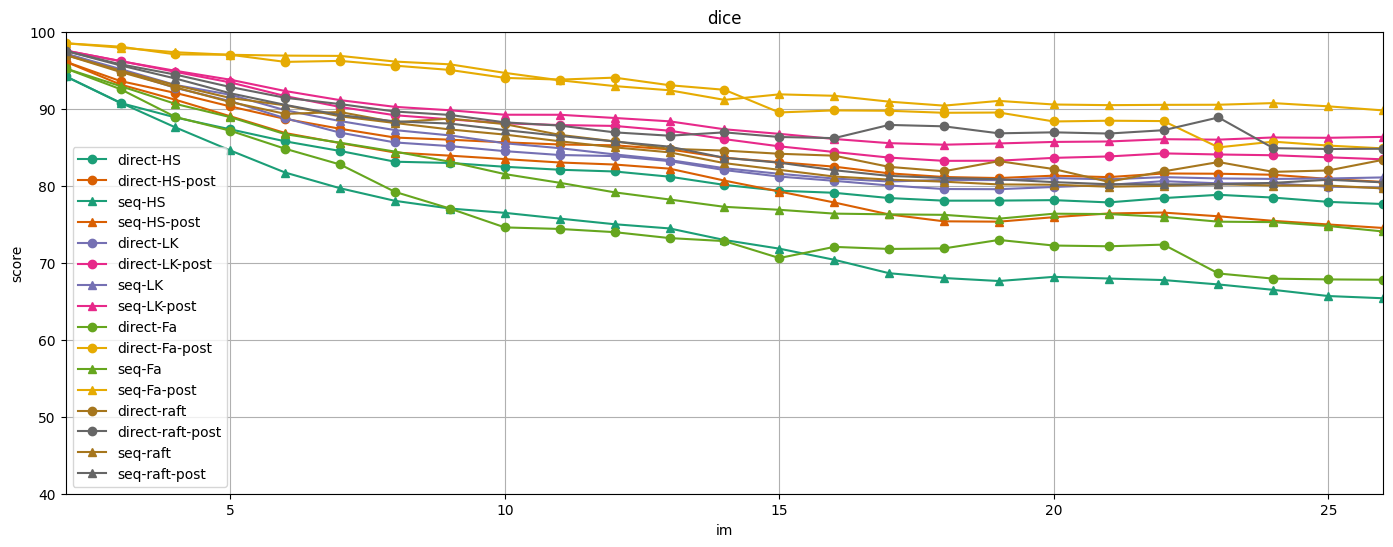

In [21]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
cmap = matplotlib.colormaps.get_cmap('Dark2')
for idx, method in enumerate(methods_raw):
    plt.plot(x,results["direct-"+method]["dices"],marker='o', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["direct-"+method+"-post"]["dices"],marker='o', color=cmap(float(idx+1/2)/len(methods_raw)))
    plt.plot(x,results["seq-"+method]["dices"],marker='^', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["seq-"+method+"-post"]["dices"],marker='^', color=cmap(float(idx+1/2)/len(methods_raw)))

plt.xlim((im_begin+1,im_end))
plt.ylim((40,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(methods_tested)
plt.title("dice")
plt.show()

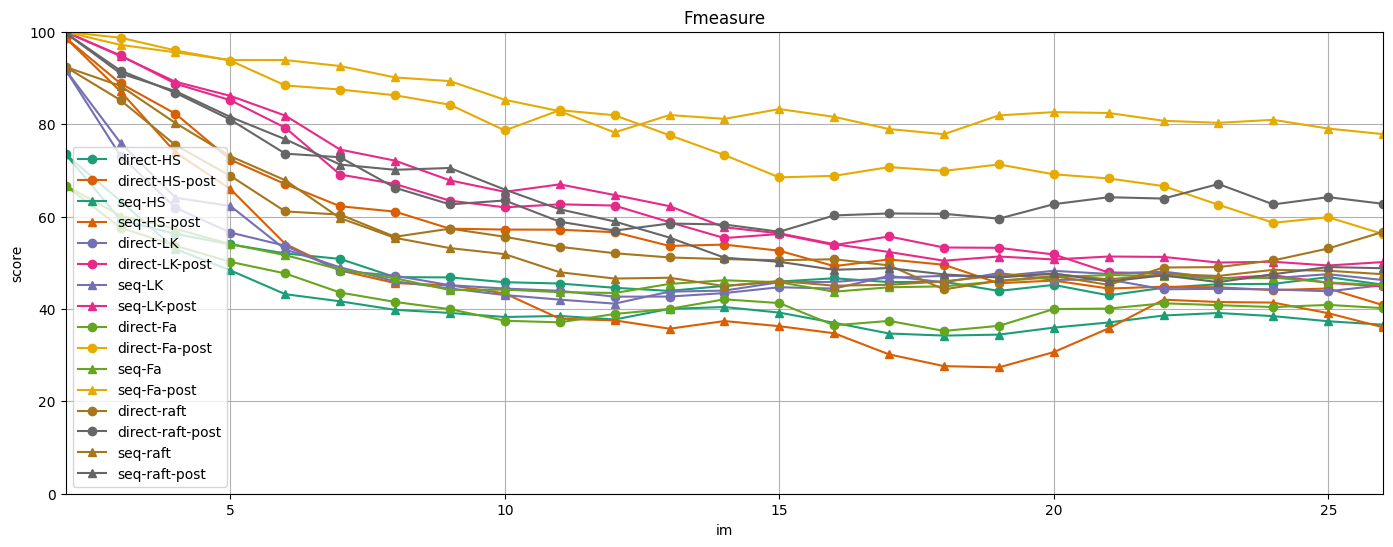

In [22]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
cmap = matplotlib.colormaps.get_cmap('Dark2')
for idx, method in enumerate(methods_raw):
    plt.plot(x,results["direct-"+method]["fmeasures"],marker='o', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["direct-"+method+"-post"]["fmeasures"],marker='o', color=cmap(float(idx+1/2)/len(methods_raw)))
    plt.plot(x,results["seq-"+method]["fmeasures"],marker='^', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["seq-"+method+"-post"]["fmeasures"],marker='^', color=cmap(float(idx+1/2)/len(methods_raw)))

plt.xlim((im_begin+1,im_end))
plt.ylim((0,100))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(methods_tested)
plt.title('Fmeasure')
plt.show()

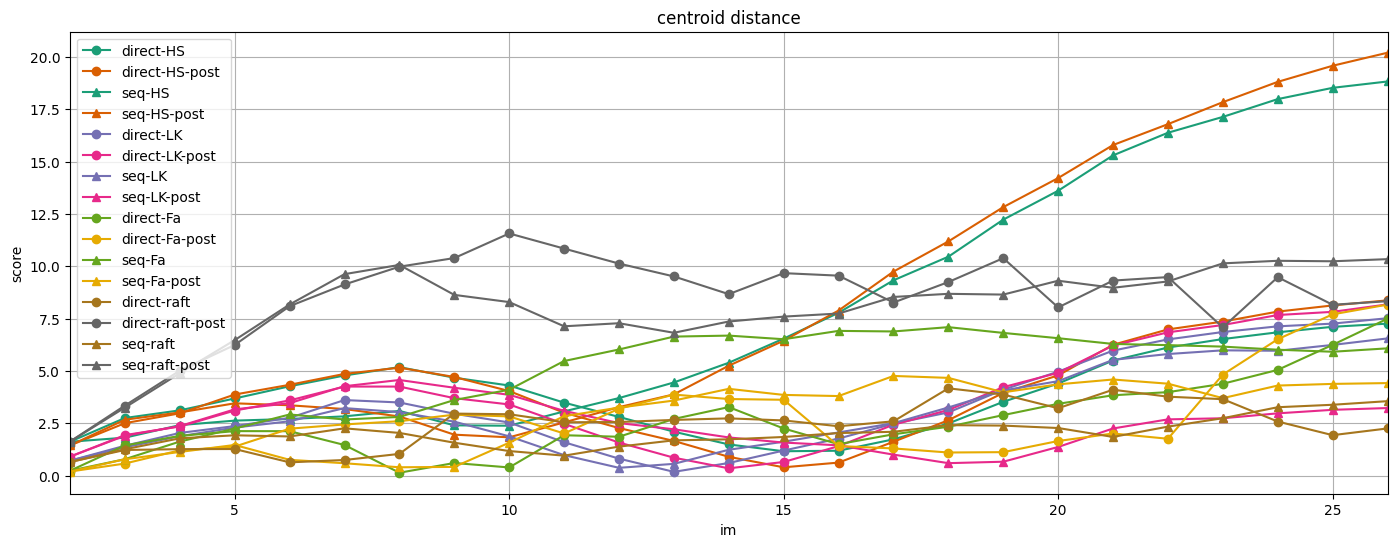

In [23]:
x = range(im_begin+1,im_end+1)
plt.figure(figsize=(17, 6))
cmap = matplotlib.colormaps.get_cmap('Dark2')
for idx, method in enumerate(methods_raw):
    plt.plot(x,results["direct-"+method]["centroid_dist"],marker='o', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["direct-"+method+"-post"]["centroid_dist"],marker='o', color=cmap(float(idx+1/2)/len(methods_raw)))
    plt.plot(x,results["seq-"+method]["centroid_dist"],marker='^', color=cmap(float(idx)/len(methods_raw)))
    plt.plot(x,results["seq-"+method+"-post"]["centroid_dist"],marker='^', color=cmap(float(idx+1/2)/len(methods_raw)))
plt.xlim((im_begin+1,im_end))
plt.ylabel('score')
plt.xlabel("im")
plt.grid()
plt.legend(methods_tested)
plt.title('centroid distance')
plt.show()

... and view the obtained **tracking results** (ground truth in green, estimated contours in red) !

In [12]:
if save_gifs:
    import imageio
    for method in methods_tested:
        with imageio.get_writer("data/gif-outputs/"+sequence_name+method+'.gif', mode='I') as writer:
            for image in results[method]["visu"]:
                image = img_as_ubyte(image)
                writer.append_data(image)

In [13]:
if save_metrics:
    for method in methods_tested:
        np.save("team1-"+sequence_name+"-dices.npy", results[method]["dices"])
        np.save("team1-"+sequence_name+"-fmeasures.npy", results[method]["fmeasures"])
        np.save("team1-"+sequence_name+"-centroids.npy", results[method]["centroid_dist"])